In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from pandas_plink import read_plink
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from joblib import Parallel, delayed
from sklearn import metrics
from math import sqrt

import random
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

/home/adbadre/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/adbadre/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/adbadre/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/adbadre/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
(bim, fam, bed)=read_plink("/work/breastcancer/clean_test/train/sig0.001")
(bim2, fam2, bed2)=read_plink("/work/breastcancer/clean_test/validation/val0.001")
(bim3, fam3, bed3)=read_plink("/work/breastcancer/clean_test/test/test0.001")

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 20.38it/s]


In [3]:
print(bim)

     chrom                       snp   cm        pos a0 a1     i
0        1                 rs4040605  0.0     856476  G  A     0
1        1          chr1_1914124_C_T  0.0    1914124  A  G     1
2        1          chr1_2501064_A_G  0.0    2501064  A  G     2
3        1          chr1_3410935_A_G  0.0    3410935  A  G     3
4        1          chr1_4515277_C_T  0.0    4515277  A  G     4
5        1          chr1_5178521_A_C  0.0    5178521  C  A     5
6        1                 rs2506889  0.0   10596022  A  G     6
7        1         chr1_10598216_A_G  0.0   10598216  A  G     7
8        1         chr1_10609973_G_T  0.0   10609973  A  C     8
9        1                 rs9430149  0.0   10612820  C  G     9
10       1                rs17035305  0.0   10616505  A  C    10
11       1         chr1_10617906_A_T  0.0   10617906  T  A    11
12       1                 rs4846235  0.0   10632235  A  G    12
13       1         chr1_10700448_C_T  0.0   10700448  G  A    13
14       1               

In [4]:
print("Convertion")
bed=bed.astype('uint8')
print("Compute")
X=bed.compute()
print("Filling Null Data")
X[np.isnan(X)]=2

Convertion
Compute
Filling Null Data


In [5]:
print("Convertion")
bedt=bed2.astype('uint8')
print("Compute")
Xt=bedt.compute()
print("Filling Null Data")
Xt[np.isnan(Xt)]=2

Convertion
Compute
Filling Null Data


In [6]:
print("Convertion")
bedtt=bed3.astype('uint8')
print("Compute")
Xtt=bedtt.compute()
print("Filling Null Data")
Xtt[np.isnan(Xtt)]=2

Convertion
Compute
Filling Null Data


In [7]:
print(X.shape)
print(Xt.shape)

(5273, 39289)
(5273, 4912)


In [8]:
Y=fam["trait"].astype("int")
Y=Y-1
Xdf=pd.DataFrame(X.T)
Xdf["Y"]=Y
#Xdf=Xdf.sample(frac=1)

In [9]:
Yt=fam2["trait"].astype("int")
Yt=Yt-1
Xdft=pd.DataFrame(Xt.T)
Xdft["Y"]=Yt
#Xdf=Xdf.sample(frac=1)

In [10]:
Ytt=fam3["trait"].astype("int")
Ytt=Ytt-1
Xdftt=pd.DataFrame(Xtt.T)
Xdftt["Y"]=Ytt
#Xdf=Xdf.sample(frac=1)

In [11]:
print(Xdf)

       0  1  2  3  4  5  6  7  8  9 ...  5264  5265  5266  5267  5268  5269  \
0      1  0  2  0  0  0  1  1  1  1 ...     0     2     2     1     1     0   
1      0  1  1  0  1  2  2  2  2  2 ...     0     0     0     2     2     1   
2      2  2  0  2  0  2  0  0  0  0 ...     0     1     1     2     2     1   
3      2  0  0  2  1  2  1  1  1  1 ...     2     1     1     1     1     2   
4      0  2  2  2  0  2  1  1  1  1 ...     2     0     0     2     2     1   
5      1  2  1  2  0  2  1  1  1  1 ...     2     1     1     1     1     1   
6      2  2  2  2  0  2  2  2  2  2 ...     2     1     1     2     2     1   
7      0  2  2  2  1  2  2  2  2  2 ...     2     0     0     1     1     0   
8      0  0  0  2  1  0  2  2  2  2 ...     2     0     0     0     0     2   
9      1  2  0  0  0  2  1  1  1  1 ...     0     1     1     1     1     0   
10     0  0  1  0  0  2  1  1  1  1 ...     0     1     1     1     1     2   
11     1  0  0  2  2  0  2  2  2  2 ...     1     2 

In [12]:
print(Xdft)

      0  1  2  3  4  5  6  7  8  9 ...  5264  5265  5266  5267  5268  5269  \
0     2  0  0  2  1  0  1  1  1  1 ...     0     1     2     2     2     1   
1     1  2  1  2  1  2  1  1  1  1 ...     1     0     0     2     2     0   
2     1  2  1  2  1  0  0  0  0  0 ...     2     1     1     2     2     2   
3     2  1  2  2  2  2  0  0  0  0 ...     0     1     1     0     0     2   
4     1  0  1  2  0  2  2  2  2  2 ...     2     1     1     1     1     1   
5     0  1  0  1  0  0  2  2  2  2 ...     2     0     0     2     2     1   
6     0  2  2  2  1  2  1  1  1  1 ...     2     2     2     1     2     1   
7     0  2  0  2  0  2  1  1  1  1 ...     1     0     0     1     1     1   
8     1  2  1  2  2  2  1  1  1  1 ...     2     1     1     1     1     1   
9     2  2  2  2  0  2  2  2  2  2 ...     2     1     1     1     1     1   
10    1  2  1  2  0  2  2  2  2  2 ...     2     2     2     1     1     1   
11    1  0  0  2  1  2  1  1  1  1 ...     2     1     1     2  

In [13]:
x=Xdf.drop(['Y'],axis=1).values
y=Xdf[['Y']].values

In [14]:
xt=Xdft.drop(['Y'],axis=1).values
yt=Xdft[['Y']].values

In [15]:
xtt=Xdftt.drop(['Y'],axis=1).values
ytt=Xdftt[['Y']].values

In [16]:
#sc = StandardScaler()
#sc.fit(x)
print(x.shape,y.shape)
x_val=xt#sc.transform(xt)
y_val=yt
x_train=x#sc.transform(x)
y_train=y
x_test=xtt#sc.transform(xtt)
y_test=ytt

(39289, 5273) (39289, 1)


In [17]:
ytt

array([[1],
       [1],
       [1],
       ...,
       [0],
       [1],
       [1]])

(array([2280.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2632.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

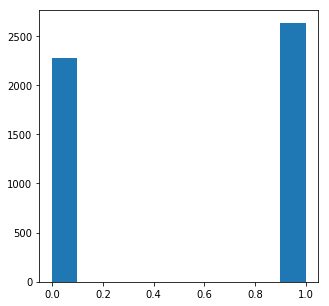

In [18]:
fig,ax=plt.subplots(figsize=(5,5))
ax.hist(ytt)

In [19]:
acc_val=[]
acc_train=[]
auc_train=[]
auc_val=[]
models=[]

In [20]:
x_train.shape

(39289, 5273)

In [22]:
#best_models=[]
for i in range(9,10):
    
    (bim, fam, bed)=read_plink("/work/breastcancer/clean_test/cv/10-fold/sig_"+str(i))
    (bim2, fam2, bed2)=read_plink("/work/breastcancer/clean_test/cv/10-fold/val_"+str(i))
    ##fetch data
    print("Convertion")
    bed=bed.astype('uint8')
    print("Compute")
    X=bed.compute()
    print("Filling Null Data")
    X[np.isnan(X)]=2
    #test
    print("Convertion")
    bed2=bed2.astype('uint8')
    print("Compute")
    X_val=bed2.compute()
    print("Filling Null Data")
    X_val[np.isnan(X_val)]=2
    Y=fam["trait"].astype("int")
    Y=Y-1
    Xdf=pd.DataFrame(X.T)
    Xdf["Y"]=Y

    Y_val=fam2["trait"].astype("int")
    Y_val=Y_val-1
    Xdf_val=pd.DataFrame(X_val.T)
    Xdf_val["Y"]=Y_val

    x_train=Xdf.drop(['Y'],axis=1).values
    y_train=Xdf[['Y']].values

    x_val=Xdf_val.drop(['Y'],axis=1).values
    y_val=Xdf_val[['Y']].values
    best_auc=0
    best_model=None
    for i in range(10,41):
        clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr',max_iter =i).fit(x_train, y_train[:,0])
        ac=clf.score(x_val, y_val)
        ac_train=clf.score(x_train, y_train)
        pred=clf.predict_proba(x_val)
        pred_train=clf.predict_proba(x_train)
        au=roc_auc_score(y_val, pred[:,1])
        au_train=roc_auc_score(y_train, pred_train[:,1])
        if best_auc<au:
            best_model=clf
            best_auc=au
        print("Step %d Accuracy_train %f AUC_train %f Accuracy_val %f AUC_val %f  "%(i,ac_train,au_train,ac,au))
    best_models.append(best_model)


Mapping files: 100%|██████████| 3/3 [00:00<00:00, 94.87it/s]

Convertion
Compute
Filling Null Data
Convertion
Compute
Filling Null Data
Step 20 Accuracy_train 0.660483 AUC_train 0.724716 Accuracy_val 0.611991 AUC_val 0.665101  
Step 21 Accuracy_train 0.661589 AUC_train 0.726510 Accuracy_val 0.610633 AUC_val 0.664318  
Step 22 Accuracy_train 0.663273 AUC_train 0.731657 Accuracy_val 0.613348 AUC_val 0.662664  
Step 23 Accuracy_train 0.665510 AUC_train 0.733923 Accuracy_val 0.608371 AUC_val 0.657758  
Step 24 Accuracy_train 0.669482 AUC_train 0.737192 Accuracy_val 0.609729 AUC_val 0.661810  
Step 25 Accuracy_train 0.672298 AUC_train 0.740188 Accuracy_val 0.612443 AUC_val 0.665166  
Step 26 Accuracy_train 0.673027 AUC_train 0.740794 Accuracy_val 0.612217 AUC_val 0.665639  
Step 27 Accuracy_train 0.674535 AUC_train 0.742084 Accuracy_val 0.611538 AUC_val 0.665774  
Step 28 Accuracy_train 0.676043 AUC_train 0.744612 Accuracy_val 0.610633 AUC_val 0.665051  
Step 29 Accuracy_train 0.677275 AUC_train 0.747282 Accuracy_val 0.610633 AUC_val 0.663410  
Step 3

KeyboardInterrupt: 

In [24]:
best_models.append(best_model)

In [25]:
scores=[]
for i in range(len(best_models)):
    (bim, fam, bed)=read_plink("/work/breastcancer/clean_test/cv/test/test_"+str(i))
    ##fetch data
    print("Convertion")
    bed=bed.astype('uint8')
    print("Compute")
    X=bed.compute()
    print("Filling Null Data")
    X[np.isnan(X)]=2
    #test
    print("Convertion")
    Y=fam["trait"].astype("int")
    Y=Y-1
    Xdf=pd.DataFrame(X.T)
    Xdf["Y"]=Y

    x_train=Xdf.drop(['Y'],axis=1).values
    y_train=Xdf[['Y']].values
    clf=best_models[i]
    ac_train=clf.score(x_train, y_train)
    pred_train=clf.predict_proba(x_train)
    au_train=roc_auc_score(y_train, pred_train[:,1]) 
    scores.append(au_train)
    print("Step %d Accuracy_test %f AUC_test %f"%(i,ac_train,au_train))


Mapping files: 100%|██████████| 3/3 [00:00<00:00, 99.34it/s]

Convertion
Compute
Filling Null Data
Convertion



Mapping files: 100%|██████████| 3/3 [00:00<00:00, 98.58it/s]

Step 0 Accuracy_test 0.596416 AUC_test 0.647769
Convertion
Compute
Filling Null Data
Convertion



Mapping files: 100%|██████████| 3/3 [00:00<00:00, 97.16it/s]

Step 1 Accuracy_test 0.597434 AUC_test 0.649803
Convertion
Compute
Filling Null Data
Convertion



Mapping files: 100%|██████████| 3/3 [00:00<00:00, 98.86it/s]

Step 2 Accuracy_test 0.594380 AUC_test 0.649432
Convertion
Compute
Filling Null Data
Convertion



Mapping files: 100%|██████████| 3/3 [00:00<00:00, 96.87it/s]

Step 3 Accuracy_test 0.599063 AUC_test 0.652472
Convertion
Compute
Filling Null Data
Convertion



Mapping files: 100%|██████████| 3/3 [00:00<00:00, 99.24it/s]

Step 4 Accuracy_test 0.591326 AUC_test 0.641597
Convertion
Compute
Filling Null Data
Convertion



Mapping files: 100%|██████████| 3/3 [00:00<00:00, 97.78it/s]

Step 5 Accuracy_test 0.605376 AUC_test 0.654227
Convertion
Compute
Filling Null Data
Convertion



Mapping files: 100%|██████████| 3/3 [00:00<00:00, 94.93it/s]

Step 6 Accuracy_test 0.594787 AUC_test 0.649397
Convertion
Compute
Filling Null Data
Convertion



Mapping files: 100%|██████████| 3/3 [00:00<00:00, 87.56it/s]

Step 7 Accuracy_test 0.604154 AUC_test 0.650357
Convertion
Compute
Filling Null Data
Convertion



Mapping files: 100%|██████████| 3/3 [00:00<00:00, 91.47it/s]

Step 8 Accuracy_test 0.594584 AUC_test 0.645202
Convertion
Compute
Filling Null Data
Convertion
Step 9 Accuracy_test 0.595602 AUC_test 0.647237


In [59]:

for i in range(17,40):
    clf = LogisticRegression(random_state=0,multi_class='ovr',max_iter =i,solver='lbfgs').fit(x_train, y_train[:,0])
    models.append(clf)
    ac=clf.score(x_val, y_val)
    ac_train=clf.score(x_train, y_train)
    acc_train.append(ac_train)
    acc_val.append(ac)
    pred=clf.predict_proba(x_val)
    print(clf.predict_proba(x_val[1:2,:]))
    pred_test=clf.predict_proba(x_test)
    pred_train=clf.predict_proba(x_train)
    au=roc_auc_score(y_val, pred[:,1])
    au_test=roc_auc_score(y_test, pred_test[:,1])
    au_train=roc_auc_score(y_train, pred_train[:,1])
    auc_train.append(au_train)
    auc_val.append(au)
    print("Step %d Accuracy_train %f AUC_train %f Accuracy_val %f AUC_val %f Accuracy_test %f AUC_test %f"%(i,ac_train,au_train,ac,au,clf.score(xt,yt),au_test))
    

[[0.48979123 0.51020877]]
Step 17 Accuracy_train 0.641528 AUC_train 0.695667 Accuracy_val 0.607288 AUC_val 0.654156 Accuracy_test 0.607288 AUC_test 0.658144
[[0.49791951 0.50208049]]
Step 18 Accuracy_train 0.641884 AUC_train 0.697342 Accuracy_val 0.607492 AUC_val 0.654994 Accuracy_test 0.607492 AUC_test 0.659005
[[0.51050203 0.48949797]]
Step 19 Accuracy_train 0.645448 AUC_train 0.703326 Accuracy_val 0.608510 AUC_val 0.657421 Accuracy_test 0.608510 AUC_test 0.659887
[[0.52076923 0.47923077]]
Step 20 Accuracy_train 0.648146 AUC_train 0.709705 Accuracy_val 0.608510 AUC_val 0.657371 Accuracy_test 0.608510 AUC_test 0.656854


KeyboardInterrupt: 

In [26]:
scores

[0.6477692140686061,
 0.6498031042465282,
 0.6494319892165195,
 0.6524715028943309,
 0.6415966171091854,
 0.6542266821883433,
 0.649396858991606,
 0.6503566966533383,
 0.6452017107587062,
 0.6472372658761978]

In [22]:
pred=models[17].predict_proba(x_val)

In [41]:
prob

array([[0.55934298, 0.44065702],
       [0.5183279 , 0.4816721 ],
       [0.58585985, 0.41414015],
       ...,
       [0.45612626, 0.54387374],
       [0.50764994, 0.49235006],
       [0.40764473, 0.59235527]])

In [42]:
yt

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [43]:
xt

array([[2, 2, 1, ..., 2, 2, 2],
       [1, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 0, 2, 2],
       [1, 1, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=uint8)

In [47]:
#best_models=[]
for i in range(1):
    
    (bim, fam, bed)=read_plink("/work/breastcancer/clean_test/cv/10-fold/sig_"+str(i))
    (bim2, fam2, bed2)=read_plink("/work/breastcancer/clean_test/cv/10-fold/val_"+str(i))
    ##fetch data
    print("Convertion")
    bed=bed.astype('uint8')
    print("Compute")
    X=bed.compute()
    print("Filling Null Data")
    X[np.isnan(X)]=2
    #test
    print("Convertion")
    bed2=bed2.astype('uint8')
    print("Compute")
    X_val=bed2.compute()
    print("Filling Null Data")
    X_val[np.isnan(X_val)]=2
    Y=fam["trait"].astype("int")
    Y=Y-1
    Xdf=pd.DataFrame(X.T)
    Xdf["Y"]=Y

    Y_val=fam2["trait"].astype("int")
    Y_val=Y_val-1
    Xdf_val=pd.DataFrame(X_val.T)
    Xdf_val["Y"]=Y_val

    x_train=Xdf.drop(['Y'],axis=1).values
    y_train=Xdf[['Y']].values

    x_val=Xdf_val.drop(['Y'],axis=1).values
    y_val=Xdf_val[['Y']].values
    best_auc=0
    best_model=None
    for i in range(30,50):
        clf=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=i).fit(x_train, y_train[:,0])#RandomForestClassifier(n_estimators=5000, max_depth=i,random_state=0,n_jobs=40).fit(x_train, y_train[:,0])
        ac=clf.score(x_val, y_val)
        ac_train=clf.score(x_train, y_train)
        pred=clf.predict_proba(x_val)
        pred_train=clf.predict_proba(x_train)
        au=roc_auc_score(y_val, pred[:,1])
        au_train=roc_auc_score(y_train, pred_train[:,1])
        if best_auc<au:
            best_model=clf
            best_auc=au
        print("Step %d Accuracy_train %f AUC_train %f Accuracy_val %f AUC_val %f  "%(i,ac_train,au_train,ac,au))
    best_models.append(best_model)



Mapping files:   0%|          | 0/3 [00:00<?, ?it/s]

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 25.50it/s]

Mapping files:   0%|          | 0/3 [00:00<?, ?it/s]

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 92.05it/s]

Convertion
Compute
Filling Null Data
Convertion
Compute
Filling Null Data
Step 30 Accuracy_train 0.598542 AUC_train 0.648029 Accuracy_val 0.601357 AUC_val 0.647868  
Step 31 Accuracy_train 0.601383 AUC_train 0.649162 Accuracy_val 0.597964 AUC_val 0.649086  
Step 32 Accuracy_train 0.600804 AUC_train 0.649917 Accuracy_val 0.600226 AUC_val 0.652021  
Step 33 Accuracy_train 0.602388 AUC_train 0.651135 Accuracy_val 0.602036 AUC_val 0.652450  
Step 34 Accuracy_train 0.603394 AUC_train 0.652104 Accuracy_val 0.604751 AUC_val 0.653308  
Step 35 Accuracy_train 0.603444 AUC_train 0.652900 Accuracy_val 0.604299 AUC_val 0.652983  
Step 36 Accuracy_train 0.604726 AUC_train 0.653789 Accuracy_val 0.605204 AUC_val 0.653263  
Step 37 Accuracy_train 0.605782 AUC_train 0.654819 Accuracy_val 0.601584 AUC_val 0.652261  
Step 38 Accuracy_train 0.606988 AUC_train 0.655674 Accuracy_val 0.604525 AUC_val 0.652945  
Step 39 Accuracy_train 0.606687 AUC_train 0.656486 Accuracy_val 0.599095 AUC_val 0.651518  
Step 4

KeyboardInterrupt: 

In [48]:
(bim, fam, bed)=read_plink("/work/breastcancer/clean_test/cv/test/test_0")
##fetch data
print("Convertion")
bed=bed.astype('uint8')
print("Compute")
X=bed.compute()
print("Filling Null Data")
X[np.isnan(X)]=2
#test
print("Convertion")
Y=fam["trait"].astype("int")
Y=Y-1
Xdf=pd.DataFrame(X.T)
Xdf["Y"]=Y
x_train=Xdf.drop(['Y'],axis=1).values
y_train=Xdf[['Y']].values
clf=best_model
ac_train=clf.score(x_train, y_train)
pred_train=clf.predict_proba(x_train)
au_train=roc_auc_score(y_train, pred_train[:,1]) 
scores.append(au_train)
print("Step %d Accuracy_test %f AUC_test %f"%(i,ac_train,au_train))



Mapping files:   0%|          | 0/3 [00:00<?, ?it/s]

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 88.77it/s]

Convertion
Compute
Filling Null Data
Convertion
Step 43 Accuracy_test 0.605376 AUC_test 0.647009


In [21]:
def print_result(clf,x_val,y_val,x_test,y_test,name):
    print("Validation:")
    print("Accuracy:",clf.score(x_val,y_val))
    print("AUC:",roc_auc_score(y_val,clf.predict_proba(x_val)[:,1]))
    print("Log Loss:",log_loss(y_val,clf.predict_proba(x_val)[:,1]))
    print(classification_report(y_val,np.round(clf.predict_proba(x_val)[:,1])))
    print("Testing:")
    print("Accuracy:",clf.score(x_test,y_test))
    print("AUC:",roc_auc_score(y_test,clf.predict_proba(x_test)[:,1]))
    print("Log Loss:",log_loss(y_test,clf.predict_proba(x_test)[:,1]))
    print(classification_report(y_test,np.round(clf.predict_proba(x_test)[:,1])))
    fpr, tpr, threshold = roc_curve(y_test,clf.predict_proba(x_test)[:,1])
    pd.DataFrame(np.array([fpr,tpr,threshold]).T).to_csv("/work/breastcancer/clean_test/results/roc_"+str(name)+"001.csv")

In [23]:
clf = LogisticRegression(random_state=0,multi_class='ovr',max_iter =20,solver='lbfgs').fit(x_train, y_train[:,0])

In [24]:
 print_result(clf,x_val,y_val,x_test,y_test,"LBFGS")

Validation:
Accuracy: 0.6085097719869706
AUC: 0.6573713185864504
Log Loss: 0.6497527253079121
             precision    recall  f1-score   support

          0       0.58      0.56      0.57      2295
          1       0.63      0.65      0.64      2617

avg / total       0.61      0.61      0.61      4912

Testing:
Accuracy: 0.6066775244299675
AUC: 0.6568535700954513
Log Loss: 0.64912991835998
             precision    recall  f1-score   support

          0       0.58      0.55      0.56      2280
          1       0.63      0.66      0.64      2632

avg / total       0.61      0.61      0.61      4912



In [26]:
fpr1, tpr1, threshold = roc_curve(y_test.T[0],clf.predict_proba(x_test)[:,1])
print(fpr1)

[0.00000000e+00 0.00000000e+00 4.38596491e-04 ... 9.99122807e-01
 9.99122807e-01 1.00000000e+00]


In [32]:
fpr2, tpr2, t = roc_curve(y_test.T[0],clf2.predict_proba(x_test)[:,1])

fpr3, tpr3, t  = roc_curve(y_test.T[0],clf5.predict_proba(x_test)[:,1])

fpr4, tpr4, t  = roc_curve(y_test.T[0],clf3.predict_proba(x_test)[:,1])

fpr5, tpr5, t  = roc_curve(y_test.T[0],clf6.predict_proba(x_test)[:,1])

fpr6, tpr6, t = roc_curve(y_test.T[0],clf7.predict_proba(x_test)[:,1])


In [31]:
a=pd.read_csv("/work/breastcancer/clean_test/results/roc_logisitc001l2.csv").drop("Unnamed: 0",axis=1)
b=pd.read_csv("/work/breastcancer/clean_test/results/dnn001_ROC.csv").drop("Unnamed: 0",axis=1)
d=pd.read_csv("/work/breastcancer/clean_test/results/roc_SVM001.csv").drop("Unnamed: 0",axis=1)

[0.         0.56762918 1.        ]
[0.         0.35448328 0.35942249 ... 0.99962006 0.99962006 1.        ]
[3.79939210e-04 3.45744681e-02 3.45744681e-02 ... 9.99620061e-01
 1.00000000e+00 1.00000000e+00]
[3.79939210e-04 6.87689970e-02 6.87689970e-02 ... 9.99620061e-01
 1.00000000e+00 1.00000000e+00]
[3.79939210e-04 6.15501520e-02 6.15501520e-02 ... 9.99620061e-01
 1.00000000e+00 1.00000000e+00]
[3.79939210e-04 2.65957447e-02 2.65957447e-02 ... 9.99620061e-01
 1.00000000e+00 1.00000000e+00]
[3.79939210e-04 5.35714286e-02 5.35714286e-02 ... 9.99620061e-01
 1.00000000e+00 1.00000000e+00]
[3.79939210e-04 5.77507599e-02 5.77507599e-02 ... 9.99620061e-01
 1.00000000e+00 1.00000000e+00]


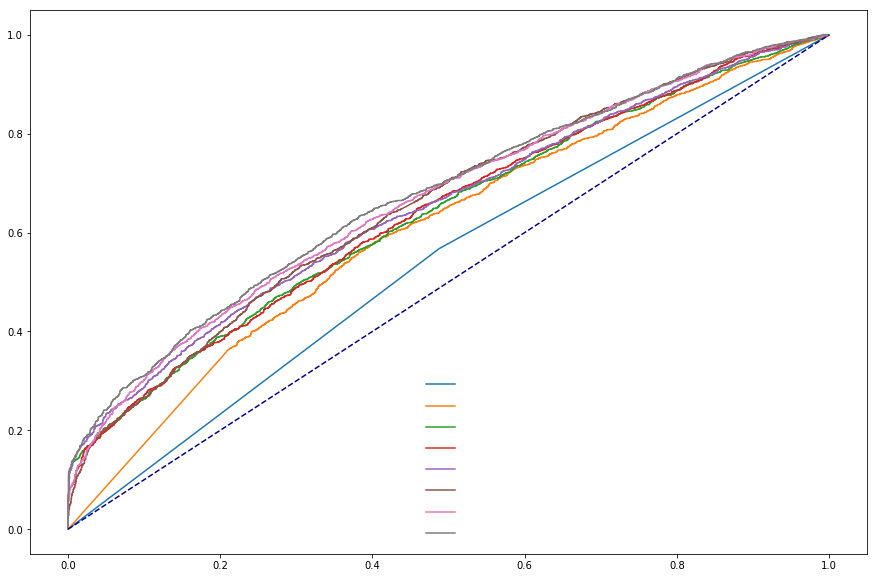

In [41]:
fpr=[fpr2,fpr3,fpr4,fpr5,fpr6,d["0"].values,a["0"].values,b["0"].values]
tpr=[tpr2,tpr3,tpr4,tpr5,tpr6,d["1"].values,a["1"].values,b["1"].values]

names=[" "," "," "," "," "," "," "," "]
def plot_roc_curve(fpr, tpr, model_names):
    fig,ax=plt.subplots(figsize=(15,10))
    for i in range(len(tpr)):
        print(tpr[i])
        ax.plot(fpr[i], tpr[i], label=str(model_names[i]))
    ax.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    #ax.set_xlabel('False Positive Rate',fontsize=15)
    #ax.set_ylabel('True Positive Rate',fontsize=15)
    #plt.title('Receiver Operating Characteristic (ROC) Curve on Testing Set',fontsize=15)
    legend = ax.legend(loc='lower center', frameon=False,shadow=True, fontsize='x-large')

    plt.show()
plot_roc_curve(fpr,tpr,names)

In [19]:
import pickle

In [20]:
with open('/work/breastcancer/clean_test/results/decisionTree.pickle', 'wb') as handle:
    pickle.dump(clf2, handle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'clf2' is not defined

In [ ]:
with open('/work/breastcancer/clean_test/results/randomForest.pickle', 'wb') as handle:
    pickle.dump(clf3, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
with open('/work/breastcancer/clean_test/results/NaiveBayes.pickle', 'wb') as handle:
    pickle.dump(clf5, handle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'clf5' is not defined

In [80]:
with open('/work/breastcancer/clean_test/results/AdaBoost.pickle', 'wb') as handle:
    pickle.dump(clf6, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [81]:
with open('/work/breastcancer/clean_test/results/GradientBoosting.pickle', 'wb') as handle:
    pickle.dump(clf7, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
clf2 = DecisionTreeClassifier(random_state=0).fit(x_train, y_train[:,0])

In [58]:
def Find_5percent_Cutoff(target, predicted,number_of_thresholds):
    print(target,predicted,min(predicted))
    for threshold in range(int(1.5*number_of_thresholds),int(number_of_thresholds*-0.5),-1):
        class_values=np.int32(predicted>threshold/number_of_thresholds)
        #print(class_values)
        #print(confusion_matrix(target,class_values))
        tn, fp, fn, tp=confusion_matrix(target,class_values).ravel()
        if tp/(tp+fp) <0.90:
            print(confusion_matrix(target,class_values))
            print("Recall:",tp/(tp+fn))

            break
    
    return threshold/number_of_thresholds 
th=Find_5percent_Cutoff(y_test[:,0],clf2.predict_proba(x_test)[:,1],1000)
print(th)

[1 1 1 ... 0 1 1] [1. 1. 0. ... 1. 0. 1.] 0.0


/home/adbadre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


[[1168 1112]
 [1138 1494]]
Recall: 0.567629179331307
0.999


In [59]:
def Find_5percent_Cutoff(target, predicted,number_of_thresholds):
    print(target,predicted,min(predicted))
    for threshold in range(int(1.5*number_of_thresholds),int(number_of_thresholds*-0.5),-1):
        class_values=np.int32(predicted>threshold/number_of_thresholds)
        #print(class_values)
        #print(confusion_matrix(target,class_values))
        tn, fp, fn, tp=confusion_matrix(target,class_values).ravel()
        if tp/(tp+fp) <0.90:
            print(confusion_matrix(target,class_values))
            print("Recall:",tp/(tp+fn))

            break
    
    return threshold/number_of_thresholds 
th=Find_5percent_Cutoff(y_test[:,0],clf3.predict_proba(x_test)[:,1],100)
print(th)

[1 1 1 ... 0 1 1] [0.51767635 0.71818291 0.55550845 ... 0.54808036 0.43709293 0.64055584] 0.3813206134881926


/home/adbadre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


[[2231   49]
 [2207  425]]
Recall: 0.1614741641337386
0.61


In [56]:
def Find_5percent_Cutoff(target, predicted,number_of_thresholds):
    print(target,predicted,min(predicted))
    for threshold in range(int(1.5*number_of_thresholds),int(number_of_thresholds*-0.5),-1):
        class_values=np.int32(predicted>threshold/number_of_thresholds)
        #print(class_values)
        #print(confusion_matrix(target,class_values))
        tn, fp, fn, tp=confusion_matrix(target,class_values).ravel()
        if tp/(tp+fp) <0.90:
            print(confusion_matrix(target,class_values))
            print("Recall:",tp/(tp+fn))

            break
    
    return threshold/number_of_thresholds 
th=Find_5percent_Cutoff(y_test[:,0],clf5.predict_proba(x_test)[:,1],1000)
print(th)

[1 1 1 ... 0 1 1] [4.12268729e-21 1.00000000e+00 1.00000000e+00 ... 9.96820669e-01
 1.11628621e-22 1.00000000e+00] 2.164741512522469e-195


/home/adbadre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


[[1618  662]
 [1457 1175]]
Recall: 0.44642857142857145
0.999


In [66]:
def Find_5percent_Cutoff(target, predicted,number_of_thresholds):
    print(target,predicted,min(predicted))
    for threshold in range(int(0.5003*number_of_thresholds),int(number_of_thresholds*0.4996),-1):
        class_values=np.int32(predicted>threshold/number_of_thresholds)
        #print(class_values)
        #print(confusion_matrix(target,class_values))
        tn, fp, fn, tp=confusion_matrix(target,class_values).ravel()
        if tp/(tp+fp) <0.95:
            print(confusion_matrix(target,class_values))
            print("Recall:",tp/(tp+fn))

            break
    
    return threshold/number_of_thresholds 
th6=Find_5percent_Cutoff(y_test[:,0],clf6.predict_proba(x_test)[:,1],10000)
print(th6)

[1 1 1 ... 0 1 1] [0.4997769  0.50008179 0.50008678 ... 0.49992345 0.50001121 0.50025978] 0.4993847728132008
[[2233   47]
 [2225  407]]
Recall: 0.15463525835866263
0.5003


In [54]:
def Find_5percent_Cutoff(target, predicted,number_of_thresholds):
    print(target,predicted,min(predicted))
    for threshold in range(int(1.5*number_of_thresholds),int(number_of_thresholds*-0.5),-1):
        class_values=np.int32(predicted>threshold/number_of_thresholds)
        #print(class_values)
        #print(confusion_matrix(target,class_values))
        tn, fp, fn, tp=confusion_matrix(target,class_values).ravel()
        if tp/(tp+fp) <0.90:
            print(confusion_matrix(target,class_values))
            print("Recall:",tp/(tp+fn))

            break
    
    return threshold/number_of_thresholds 
th=Find_5percent_Cutoff(y_test[:,0],clf7.predict_proba(x_test)[:,1],1000)
print(th)

[1 1 1 ... 0 1 1] [0.42569805 0.90768242 0.48521685 ... 0.45776419 0.45460681 0.91055938] 0.18910982970151738


/home/adbadre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


[[2226   54]
 [2164  468]]
Recall: 0.1778115501519757
0.701


In [25]:
with open('/work/breastcancer/clean_test/results/decisionTree.pickle', 'rb') as handle:
    clf2=pickle.load(handle)

EOFError: Ran out of input

In [26]:
with open('/work/breastcancer/clean_test/results/randomForest.pickle', 'rb') as handle:
    clf3=pickle.load(handle)

In [24]:
with open('/work/breastcancer/clean_test/results/SVM.pickle', 'rb') as fid:
    cl4 = pickle.load(fid)

In [28]:
with open('/work/breastcancer/clean_test/results/AdaBoost.pickle', 'rb') as handle:
    clf6=pickle.load(handle)

In [29]:
with open('/work/breastcancer/clean_test/results/GradientBoosting.pickle', 'rb') as fid:
    gnb_loaded = pickle.load(fid)

In [30]:
clf7=gnb_loaded

In [29]:
results=pd.DataFrame(clf6.predict_proba(x_test)[:,1])


In [35]:
y_test[y_test==0].shape

(2280,)

Text(0,0.5,' ')

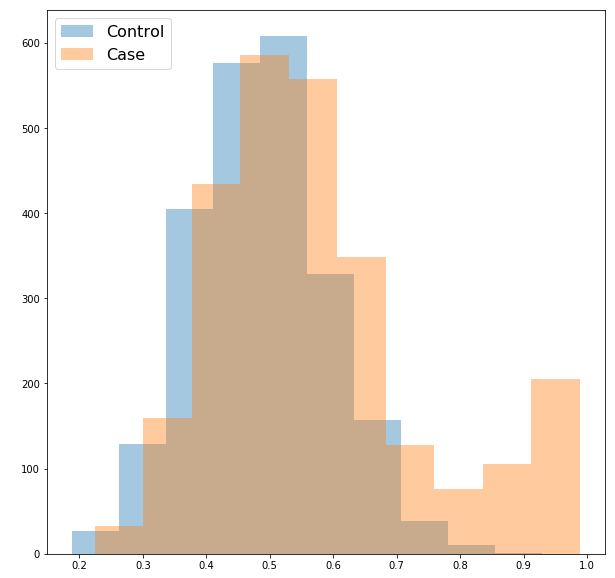

In [36]:
target=pd.DataFrame(y_test)

results=pd.DataFrame(clf7.predict_proba(x_test)[:,1])
target.columns=["Prediction Target"]
result_pred=pd.concat([results,target],axis=1)
result_pred.columns=["Predicted","Prediction Target"]
fig, ax = plt.subplots(figsize = (10,10))
r=result_pred.groupby('Prediction Target')['Predicted']
r.plot(kind='hist',alpha=.4,legend=True)
#ax.set_xlabel("PRS",fontsize=15)
plt.legend(fontsize=15)
ax.legend(['Control','Case'],loc="upper left",fontsize=16)
ax.set_ylabel(" ")


In [30]:
 print_result(clf2,x_val,y_val,x_test,y_test,"DecisionTree")

Validation:
Accuracy: 0.5364413680781759
AUC: 0.5350974814415215
Log Loss: 16.01092927580392
             precision    recall  f1-score   support

          0       0.50      0.51      0.51      2295
          1       0.57      0.56      0.56      2617

avg / total       0.54      0.54      0.54      4912

Testing:
Accuracy: 0.5419381107491856
AUC: 0.5399549405428464
Log Loss: 15.821078184220562
             precision    recall  f1-score   support

          0       0.51      0.51      0.51      2280
          1       0.57      0.57      0.57      2632

avg / total       0.54      0.54      0.54      4912



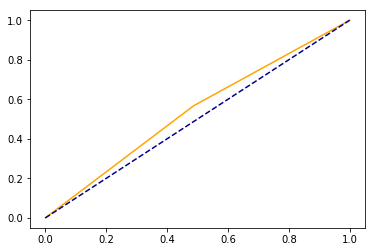

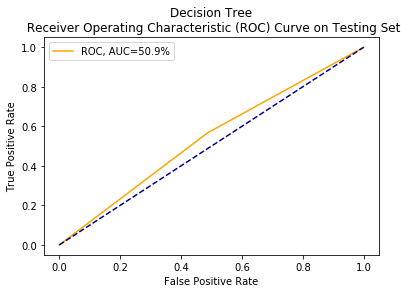

In [31]:
fpr, tpr, threshold = roc_curve(y_test.T[0],clf2.predict_proba(x_test)[:,1])
plt.plot(fpr, tpr, color='orange', label='ROC, ')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

plt.show()
def plot_roc_curve(fpr, tpr, model_name,AUC):
    plt.plot(fpr, tpr, color='orange', label='ROC, AUC='+str(np.round(AUC*100,1))+"%")
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str(model_name)+' Receiver Operating Characteristic (ROC) Curve on Testing Set')
    
    plt.legend()
    plt.show()
plot_roc_curve(fpr,tpr,"Decision Tree\n",0.509)

In [32]:
clf3=RandomForestClassifier(n_estimators=3000, max_depth=10,
                             random_state=0,n_jobs=40).fit(x_train, y_train[:,0])

In [33]:
 print_result(clf3,x_val,y_val,x_test,y_test,"RandomForest")

Validation:
Accuracy: 0.5956840390879479
AUC: 0.6409559416684774
Log Loss: 0.6568050203496386
             precision    recall  f1-score   support

          0       0.58      0.46      0.52      2295
          1       0.60      0.71      0.65      2617

avg / total       0.59      0.60      0.59      4912

Testing:
Accuracy: 0.5826547231270358
AUC: 0.6363368527702234
Log Loss: 0.6562956639496569
             precision    recall  f1-score   support

          0       0.57      0.44      0.49      2280
          1       0.59      0.71      0.65      2632

avg / total       0.58      0.58      0.57      4912



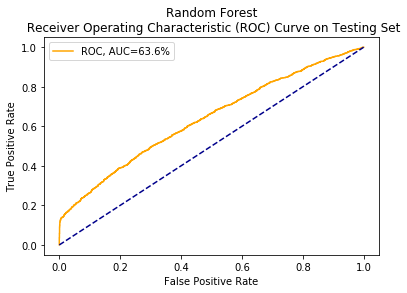

In [36]:
fpr, tpr, threshold = roc_curve(y_test.T[0],clf3.predict_proba(x_test)[:,1])
def plot_roc_curve(fpr, tpr, model_name,AUC):
    plt.plot(fpr, tpr, color='orange', label='ROC, AUC='+str(np.round(AUC*100,1))+"%")
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str(model_name)+' Receiver Operating Characteristic (ROC) Curve on Testing Set')
    
    plt.legend()
    plt.show()
plot_roc_curve(fpr,tpr,"Random Forest\n",0.636)

In [34]:
roc_auc_score(y_test,clf3.predict_proba(x_test)[:,1])

0.6363368527702234

In [88]:
tuned_parameters=[{"n_estimators":[x*50+1 for x in range(50)],"max_depth":[x+1 for x in range(10)]}]

In [37]:
 print_result(clf3,x_val,y_val,x_test,y_test,"RandomForest")

Validation:
Accuracy: 0.5956840390879479
AUC: 0.6409559416684774
Log Loss: 0.6568050203496386
             precision    recall  f1-score   support

          0       0.58      0.46      0.52      2295
          1       0.60      0.71      0.65      2617

avg / total       0.59      0.60      0.59      4912

Testing:
Accuracy: 0.5826547231270358
AUC: 0.6363368527702234
Log Loss: 0.6562956639496569
             precision    recall  f1-score   support

          0       0.57      0.44      0.49      2280
          1       0.59      0.71      0.65      2632

avg / total       0.58      0.58      0.57      4912



In [38]:
x_t

NameError: name 'x_t' is not defined

In [ ]:
clf4 = SVC().fit(x_train, y_train[:,0])

In [ ]:
 print_result(clf4,x_val,y_val,x_test,y_test,"SVM")

In [ ]:
def Find_5percent_Cutoff(target, predicted,number_of_thresholds):
    print(target,predicted,min(predicted))
    for threshold in range(int(1.5*number_of_thresholds),int(number_of_thresholds*-0.5),-1):
        class_values=np.int32(predicted>threshold/number_of_thresholds)
        #print(class_values)
        #print(confusion_matrix(target,class_values))
        tn, fp, fn, tp=confusion_matrix(target,class_values).ravel()
        if tp/(tp+fp) <0.95:
            print(confusion_matrix(target,class_values))
            print("Recall:",tp/(tp+fn))

            break
    
    return threshold/number_of_thresholds 
th=Find_5percent_Cutoff(y_test[:,0],clf4.predict_proba(x_test)[:,1],1000)
print(th)

In [ ]:
fpr, tpr, threshold = roc_curve(y_test.T[0],clf3.predict_proba(x_test)[:,1])
def plot_roc_curve(fpr, tpr, model_name,AUC):
    plt.plot(fpr, tpr, color='orange', label='ROC, AUC='+str(np.round(AUC*100,1))+"%")
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str(model_name)+' Receiver Operating Characteristic (ROC) Curve on Testing Set')
    
    plt.legend()
    plt.show()
plot_roc_curve(fpr,tpr,"Random Forest\n",0.636)

In [22]:
from sklearn.naive_bayes import GaussianNB
clf5=GaussianNB().fit(x_train, y_train[:,0])


In [23]:
 print_result(clf5,x_val,y_val,x_test,y_test,"naiveBayes")

NameError: name 'print_result' is not defined

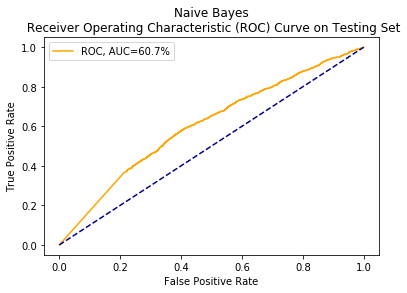

In [41]:
fpr, tpr, threshold = roc_curve(y_test.T[0],clf5.predict_proba(x_test)[:,1])
def plot_roc_curve(fpr, tpr, model_name,AUC):
    plt.plot(fpr, tpr, color='orange', label='ROC, AUC='+str(np.round(AUC*100,1))+"%")
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str(model_name)+' Receiver Operating Characteristic (ROC) Curve on Testing Set')
    
    plt.legend()
    plt.show()
plot_roc_curve(fpr,tpr,"Naive Bayes\n",0.607)

In [42]:
print(clf5.score(x_test, y_test))

0.5704397394136808


In [43]:
clf6=AdaBoostClassifier(n_estimators=2000).fit(x_train, y_train[:,0])

In [44]:
 print_result(clf6,x_val,y_val,x_test,y_test,"ADABoost")

Validation:
Accuracy: 0.5865228013029316
AUC: 0.6354997448391321
Log Loss: 0.6930312885348667
             precision    recall  f1-score   support

          0       0.56      0.56      0.56      2295
          1       0.61      0.61      0.61      2617

avg / total       0.59      0.59      0.59      4912

Testing:
Accuracy: 0.5928338762214984
AUC: 0.6395585039726978
Log Loss: 0.6930279348494839
             precision    recall  f1-score   support

          0       0.56      0.55      0.56      2280
          1       0.62      0.63      0.62      2632

avg / total       0.59      0.59      0.59      4912



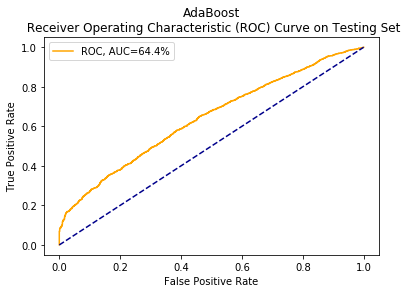

In [45]:
fpr, tpr, threshold = roc_curve(y_test.T[0],clf6.predict_proba(x_test)[:,1])
def plot_roc_curve(fpr, tpr, model_name,AUC):
    plt.plot(fpr, tpr, color='orange', label='ROC, AUC='+str(np.round(AUC*100,1))+"%")
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str(model_name)+' Receiver Operating Characteristic (ROC) Curve on Testing Set')
    
    plt.legend()
    plt.show()
plot_roc_curve(fpr,tpr,"AdaBoost\n",0.644)

In [46]:
roc_auc_score(y_test,clf6.predict_proba(x_test)[:,1])

0.6395585039726978

In [47]:
clf6.score(x_test,y_test)

0.5928338762214984

In [48]:
print(clf6.score(x_val, y_val))

0.5865228013029316


In [49]:
clf7=GradientBoostingClassifier(n_estimators=400).fit(x_train, y_train[:,0])

In [50]:
print_result(clf7,x_val,y_val,x_test,y_test,"GradientBoosting")

Validation:
Accuracy: 0.6089169381107492
AUC: 0.6575268293535731
Log Loss: 0.6379982177593536
             precision    recall  f1-score   support

          0       0.58      0.58      0.58      2295
          1       0.63      0.63      0.63      2617

avg / total       0.61      0.61      0.61      4912

Testing:
Accuracy: 0.6019951140065146
AUC: 0.6510541646669866
Log Loss: 0.6376466486145423
             precision    recall  f1-score   support

          0       0.57      0.57      0.57      2280
          1       0.63      0.63      0.63      2632

avg / total       0.60      0.60      0.60      4912



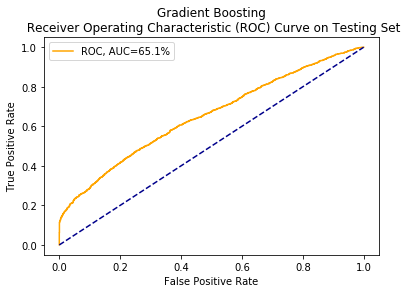

In [51]:
fpr, tpr, threshold = roc_curve(y_test.T[0],clf7.predict_proba(x_test)[:,1])
def plot_roc_curve(fpr, tpr, model_name,AUC):
    plt.plot(fpr, tpr, color='orange', label='ROC, AUC='+str(np.round(AUC*100,1))+"%")
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str(model_name)+' Receiver Operating Characteristic (ROC) Curve on Testing Set')
    
    plt.legend()
    plt.show()
plot_roc_curve(fpr,tpr,"Gradient Boosting\n",0.651)

In [32]:
roc_auc_score(y_test,clf7.predict_proba(x_test)[:,1])

0.6509051885031728

In [51]:
tp/(tp+fn)

NameError: name 'tp' is not defined

In [ ]:
print(clf7.score(x_val, y_val))

In [56]:
print(clf.score(x_val, y_val))
print(clf.score(x_train, y_train))


0.805
1.0


In [12]:
clf2.score(x_val, y_val)

0.54125

In [26]:
clf3.score(x_val, y_val)

0.5325

In [ ]:
clf4.score(x_val, y_val)

In [50]:
pred=clf.predict(x_val)


In [20]:
pred3=clf3.predict(x_val)

In [19]:
pred4=clf4.predict(x_val)

In [63]:
pred_proba=clf.predict_proba(x_val)

In [ ]:
pred_proba3=clf3.predict_proba(x_val)

In [ ]:
pred_proba4=clf4.predict_proba(x_val)

In [68]:
roc_auc_score(y_val, pred)

0.8133266296004429

In [40]:
#roc_auc_score(y_val, pred)

In [23]:
results=pd.DataFrame(pred[:,1])

<IPython.core.display.Javascript object>


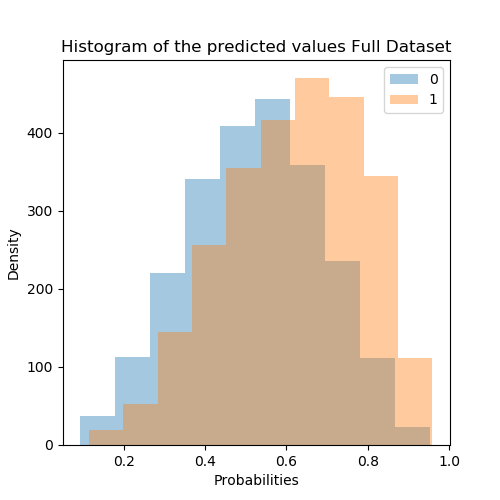

Text(0.5,1,'Histogram of the predicted values Full Dataset')

In [24]:
target=pd.DataFrame(y_val)
target.columns=["Prediction Target"]
result_pred=pd.concat([results,target],axis=1)
result_pred.columns=["Predicted","Prediction Target"]
fig, ax = plt.subplots(figsize = (5,5))
r=result_pred.groupby('Prediction Target')['Predicted']
r.plot(kind='hist',alpha=.4,legend=True)
ax.set_xlabel("Probabilities")
ax.set_ylabel("Density")
ax.set_title('Histogram of the predicted values Full Dataset')
#plt.savefig('/work/breastcancer/histprediction_0.1_Bigger.png')

In [51]:
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold']) 
th=Find_Optimal_Cutoff(y_val,pred[:,1])


/home/adbadre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


In [52]:
y_val[:,0]

array([0, 1, 1, ..., 0, 0, 0])

In [53]:
func=lambda x: 1 if x >th[0]  else 0
vfunc = np.vectorize(func)
out_t=vfunc(pred[:,1])
print(th)
cm=confusion_matrix(y_val[:,0],out_t)
print(cm)
#open('/work/breastcancer/logistic_sklearn.txt', 'w')
#with open('/work/breastcancer/logistic_sklearn.txt', 'a+') as file:
    #file.write("Classification Report1:\n")
    #file.write(classification_report(y_val.T[0],np.round(out.T[0])))
print(classification_report(y_val[:,0],np.round(pred[:,1])))
    #file.write("Classification Report2:\n")
print(classification_report(y_val,np.round(out_t)))
    #file.write(classification_report(y_val.T[0],np.round(out_t)))
    #file.write("Optimal Theresold:"+str(th)+" Confusion Matrix:TP->"+str(cm[0,0])
     #          +" FP->"+str(cm[0,1])+" FN"+str(cm[1,0])+" TN"+str(cm[1,1]))
    #file.write("\n"+str())

[0.4906969227750291]
[[1246  635]
 [ 716 1403]]
             precision    recall  f1-score   support

          0       0.63      0.68      0.65      1881
          1       0.69      0.65      0.67      2119

avg / total       0.66      0.66      0.66      4000

             precision    recall  f1-score   support

          0       0.64      0.66      0.65      1881
          1       0.69      0.66      0.68      2119

avg / total       0.66      0.66      0.66      4000



In [23]:
1525/(1525+356)

0.8107389686337054

In [19]:
fpr,tpr,_=roc_curve(y_val,pred[:,1])

<IPython.core.display.Javascript object>


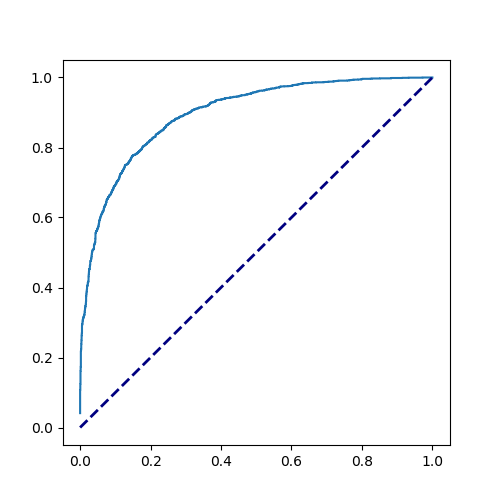

In [20]:
fig,ax=plt.subplots(figsize=(5,5))
ax.plot(fpr,tpr)
ax.plot([0,1],[0,1],color='navy', lw=2, linestyle='--')